In [1]:
import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import UnivariateSpline

def has_keys(key_array, data):
    return sum([k in data.keys() for k in key_array]) == len(key_array)
        
def plot_variable(name, data, units='', label=''):
    f,ax = plot.subplots(figsize=(20,3))
    if type(name) == str:
        name = [name]
    for n in name:
        ax.plot(data[n])
    ax.set_ylabel('{} [{}]'.format(name[0], units) if units else name[0])
    plot.show();

### Estimating gear

Speed/RPM

In [2]:
gear_radii_def = np.array([0.0 ,10.0 ,18.0 , 28.5, 40.0, 50.0])

def compute_gear(data):
    if has_keys(['Vehicle Speed', 'Engine RPM'], data):
        data['Gear Radius'] = data['Vehicle Speed']/data['Engine RPM']/60e-5
        data['Gear'] = np.array([np.argmin(np.abs(gear_radii_def - g)) for g in data['Gear Radius'].rolling(5, center=True).median()])
    
def plot_gear(data):
    compute_gear(data)

    f,ax = plot.subplots(figsize=(20,3))
    ax.plot(data.index, np.array([gear_radii_def[g] for g in data['Gear']]), alpha=1, c='k')
    ax.plot(data['Gear Radius'], lw=2, alpha=0.7)
    for i in gear_radii_def[1:]:
        ax.axhline(i, ls='dashed', c='k', alpha=0.2)
    ax.set_ylabel("Gear effective radius (cm)")
    ax.set_ylim(0,55)

### Other derived quantities

Reference: [DashCommand CALC PID](https://www.palmerperformance.com/download/CALC_PID_Reference.pdf)

#### Mass Air Flow (g/s)
__Method A__

MAF [g/s] = 1.184 [g/l] * displacement [l/intake stroke] * load_abs / 100 * engine_speed [r/min] / 2 [r/intake stroke] / 60 [sec/min]

__Method B__

MAF [g/s] = (MAP/IAT) * (M/R) * (RPM/60) * (ED/2) * VE, where

* MAP [kPa] is the manifold absolute pressure
* IAT [K] is the intake air temperature
* M [g/mol] is the molecular mass of air R [J/(K*mol)] is gas constant for air RPM [r/min] is the engine speed
* ED [l] is the engine displacement
* VE is the volumetric efficiency

In [3]:
def compute_maf(data):
    if has_keys(['Absolute Engine Load', 'Engine RPM'], data):
        # (1.184 g/l) * 1 l * (1/60) Hz / 2 = 0.00986666667 g/s
        data['MAF_A'] = 0.0098666666 * data['Absolute Engine Load']/100 * data['Engine RPM']
        
    if has_keys(['Intake Manifold Pressure', 'Intake Air Temperature', 'Engine RPM'], data):
        # (1 kPa / 1K) * ((28.97 g/mol)/(8.3144598 joules/K/mol)) * ((1/60) Hz) * (1 l /2) = 0.0290357609 g/s
        data['MAF_B'] = 0.0290357609 * data['Intake Manifold Pressure'] / (data['Intake Air Temperature'] + 273) * data['Engine RPM'] * 0.75
    
    if has_keys(['MAF_A'], data):
        data['MAF'] = data['MAF_A']
        
    elif has_keys(['MAF_B'], data):
        data['MAF'] = data['MAF_B']

#### Fuel Consumption

fuel_flow = mass_air_flow / (AFRactual * fuel_density) where AFRactual = lambda * AFRstoich

In [4]:
def compute_fuel_consumption(data, ethanol_percent=None, maf=None):
    compute_maf(data)
    maf = maf if maf else 'MAF'
    if has_keys(['Commanded Equivalence Ratio'], data):
        ETHANOL_PERCENT = data['Ethanol fuel %'] if has_keys(['Ethanol fuel %'], data) else (ethanol_percent if ethanol_percent else 25)
        data['AFR'] = (14.7 + (9.0 - 14.7)*ETHANOL_PERCENT/100) * data['Commanded Equivalence Ratio']/100 # for now, assuming commanded EQ = actual
                
    if has_keys([maf, 'AFR'], data):
        # 1 g/s / 1 g/ml = 1e-3 l/s
        data['Fuel Flow'] = 1e-3*data[maf] / data['AFR'] / 0.800
        data['Integrated Fuel Burned'] = integrate.cumulative_trapezoid(data['Fuel Flow'], data.index.astype(np.int64) / 10**9, initial=0)
    
    if has_keys(['Vehicle Speed', 'Fuel Flow'], data):
        data['Fuel Consumption'] = data['Vehicle Speed']/3600 /data['Fuel Flow']

### Variables interesting to measure (0.1 sec per variable)

* Coolant Temperature
* Intake Manifold Pressure
* Engine RPM
* Vehicle Speed
* Intake Air Temperature
* Fuel Level Input
* Distance since ECU reset
* CAT Temperature B1S1
* Absolute Engine Load
* Commanded Equivalence Ratio
* Comm. Throttle Actuator Cntrl
* Ethanol fuel %

or:

* Engine RPM
* Vehicle Speed
* Fuel Level Input
* Distance since ECU reset
* Absolute Engine Load
* Commanded Equivalence Ratio
* Comm. Throttle Actuator Cntrl

### Corrida 1

In [5]:
data = pd.read_csv('./2021.05.30-13.32.49.csv', delimiter='\t', parse_dates=['Time [s]'], index_col='Time [s]')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5283 entries, 2021-05-30 11:52:57.647000 to 2021-05-30 13:32:48.986000
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Coolant Temperature            5283 non-null   float64
 1   Intake Manifold Pressure       5283 non-null   float64
 2   Engine RPM                     5283 non-null   float64
 3   Vehicle Speed                  5283 non-null   float64
 4   Timing Advance (Cyl. #1)       5283 non-null   float64
 5   Intake Air Temperature         5283 non-null   float64
 6   Fuel Level Input               5283 non-null   float64
 7   Distance since ECU reset       5283 non-null   float64
 8   CAT Temperature B1S1           5283 non-null   float64
 9   Absolute Engine Load           5283 non-null   float64
 10  Commanded Equivalence Ratio    5283 non-null   float64
 11  Comm. Throttle Actuator Cntrl  5283 non-null   float64
 12

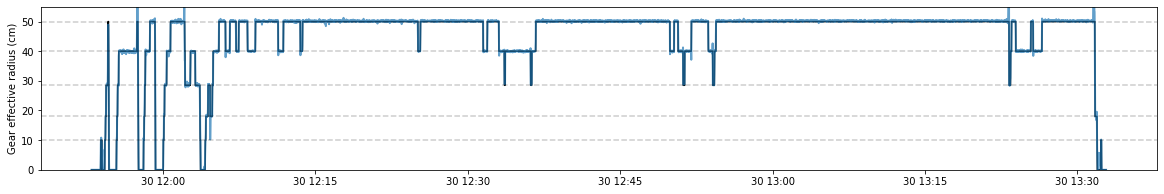

In [7]:
plot_gear(data)

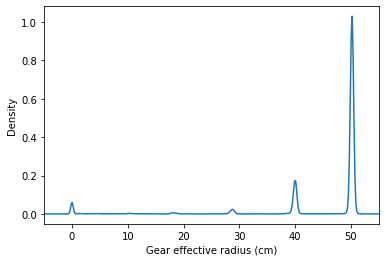

In [12]:
data['Gear Radius'].plot.kde(0.02)
plot.xlabel('Gear effective radius (cm)');
plot.xlim(-5,55);

In [8]:
compute_fuel_consumption(data, ethanol_percent=39)

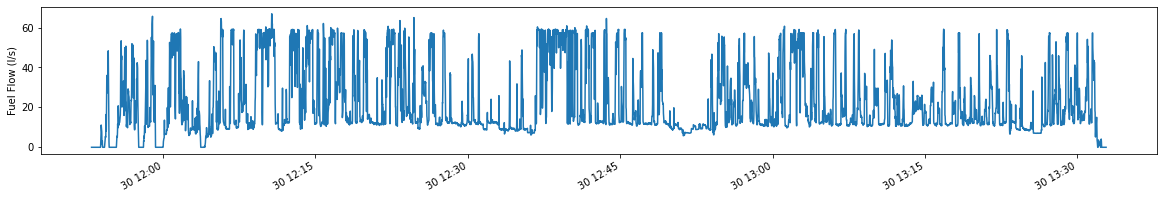

In [9]:
data['Fuel Consumption'].plot(figsize=(20,3), xlabel='', ylabel='Fuel Flow (l/s)');

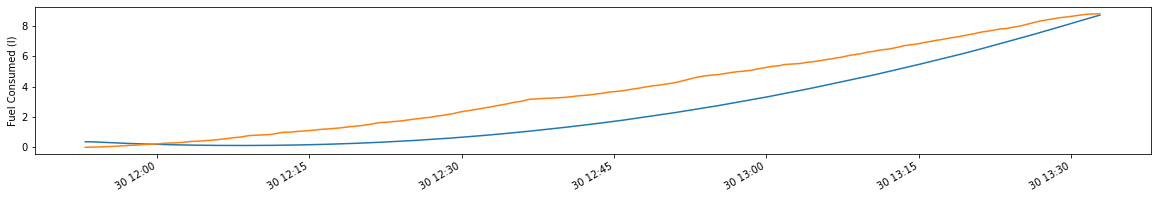

In [10]:
# fli = np.poly1d(np.polyfit(np.arange(len(data)), data['Fuel Level Input'], deg=2))(np.arange(len(data)))
fli = UnivariateSpline(np.arange(len(data)), data['Fuel Level Input'], s=np.inf, k=2)(np.arange(len(data)))
# fli = data['Fuel Level Input'].rolling(100, win_type='gaussian').mean(std=20)
# fli = data['Fuel Level Input'].rolling(100).mean()
# fli = data['Fuel Level Input']

f,ax = plot.subplots(figsize=(20,3))
ax.plot(data.index, 51.6 - fli*51.6/100)
data['Integrated Fuel Burned'].plot(ax=ax, xlabel='', ylabel='Fuel Consumed (l)');

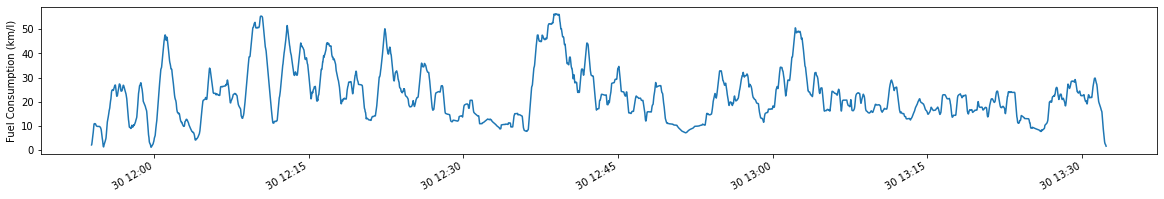

In [11]:
data['Fuel Consumption'].rolling(50, center=True).mean().plot(figsize=(20,3), xlabel='', ylabel='Fuel Consumption (km/l)');

<AxesSubplot:ylabel='Coolant Temperature (Celsius)'>

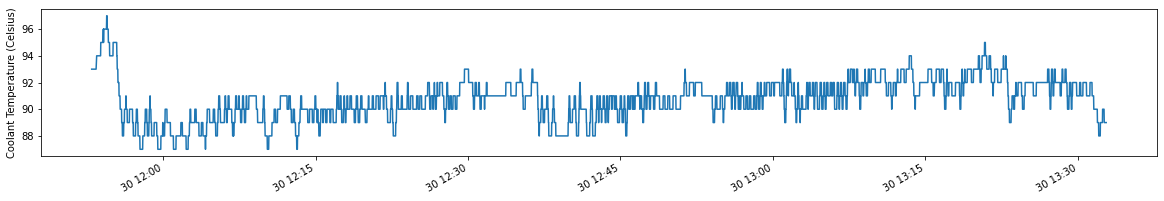

In [15]:
data['Coolant Temperature'].plot(figsize=(20,3), xlabel='', ylabel='Coolant Temperature (Celsius)')

<AxesSubplot:ylabel='CAT Temperature (Celsius)'>

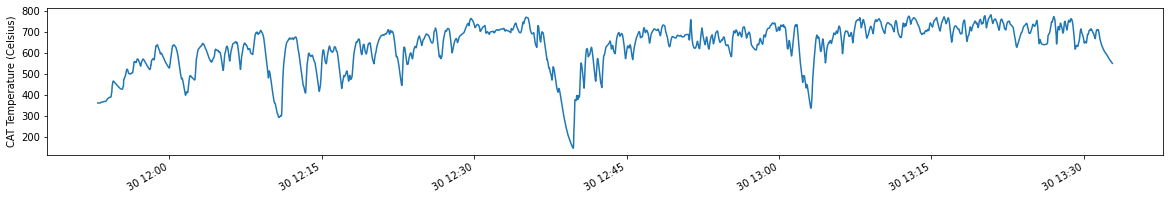

In [16]:
data['CAT Temperature B1S1'].plot(figsize=(20,3), xlabel='', ylabel='CAT Temperature (Celsius)')

<AxesSubplot:ylabel='Speed (km/h)'>

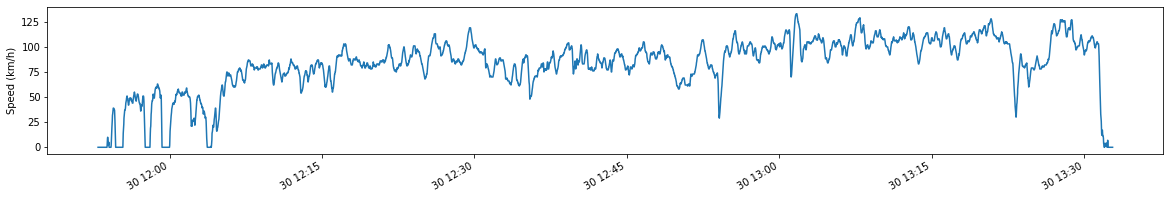

In [17]:
data['Vehicle Speed'].plot(figsize=(20,3), xlabel='', ylabel='Speed (km/h)')